# Análisis de Clasificación Automática de Modulación  
Este notebook consolida y visualiza los resultados obtenidos con distintas arquitecturas y escenarios de canal.

**Estructura**  
1. Descubrimiento de experimentos  
2. Carga y parsing de reportes (`classification_report.json` y `effects_report.json`)  
3. DataFrame maestro  
4. Métricas agregadas + IC 95 %  
5. Visualización principal (Accuracy ± IC)  
6. Tests estadísticos (Friedman/Nemenyi o Wilcoxon)  
7. Visualizaciones adicionales  
   - Heatmap F1 por clase × escenario  
   - Curvas de efectos (SNR, fase, taps)  
   - Boxplot de accuracies  
   - Radar de robustez relativa


In [1]:
# Colab: asegurar versiones recientes
# !pip install -q scikit-posthocs==0.7 seaborn==0.13

from pathlib import Path
import json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib as mpl


RESULTS_ROOT = Path().resolve() / "outputs"

/Users/juanpabloperezvargas/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Declaración escenarios

In [2]:
ESCS_BY_PARAM = {

    'snr_db': {
        'constants': {
            'num_taps': 2,
            'phase_offset': {'low': 0.0, 'high': 45.0},
        },
        'escs': {
            'ESC_1': {'low': 0.0, 'high': 4.0},
            'ESC_2': {'low': 4.0, 'high': 8.0},
            'ESC_3': {'low': 8.0, 'high': 12.0},
            'ESC_4': {'low': 12.0, 'high': 16.0},
            'ESC_5': {'low': 16.0, 'high': 20.0},
        },
    },

    'num_taps': {
        'constants': {
            'snr_db': {'low': 8.0, 'high': 12.0}, 
            'phase_offset': {'low': 0.0, 'high': 45.0}
        },
        'escs': {
            # 'ESC_6': {'num_tap': 1},
            'ESC_3': {'num_tap': 2},
            'ESC_7': {'num_tap': 4},
            'ESC_8': {'num_tap': 6},
        },
    },
    'phase_offset': {
        'constants': {
            'snr_db': {'low': 8.0, 'high': 12.0}, 
            'num_taps': 2
        },
        'escs': {
            'ESC_3': {'low': 0.0, 'high': 45.0},
            'ESC_9': {'low': 45.0, 'high': 90.0},
            # 'ESC_10': {'low': 90.0, 'high': 135.0},
            'ESC_11': {'low': 135.0, 'high': 180.0},
        },
    },
}

ESCS_ORDER = {p: list(v["escs"]) for p, v in ESCS_BY_PARAM.items()}

## **Estilos para gráficas**

In [3]:
plt.rcParams.update({"figure.dpi": 110, "axes.grid": True})
# Render interno como SVG (vectorial en el notebook)
%config InlineBackend.figure_format = "svg"

def set_plot_style():
    """Estilo global 'print-ready'."""
    sns.set_theme(context="paper",
                  style="white",
                  font="DejaVu Sans",
                  palette="Set2",
                  rc={
                      "axes.edgecolor": "#444444",
                      "axes.linewidth": 0.7,
                      "axes.grid": True,
                      "grid.alpha": 0.18,
                      "grid.linestyle": "--",
                      "axes.titlesize": 16,
                      "axes.titleweight": "bold",
                      "axes.labelsize": 12,
                      "xtick.labelsize": 11,
                      "ytick.labelsize": 11,
                      "legend.fontsize": 9,
                      "legend.frameon": False,
                      "lines.linewidth": 1.8,
                      "lines.markersize": 3,
                      "figure.dpi": 120,
                  })
    mpl.rcParams["axes.spines.top"]   = False
    mpl.rcParams["axes.spines.right"] = False

set_plot_style()


PALETTE_ARCH  = sns.color_palette("Set2", 8)        # hasta 8 arquitecturas
MARKERS_ESC   = ["o", "s", "D", "^", "v", "P", "X"] # 7 escenarios máx.

INTENSE_ARCH_PALETTE = sns.color_palette("Set1",  9)   # rojo, azul, verde, etc.
INTENSE_MARKERS_ESC  = ["o","s","D","^","v","P","X"]   # 7 escenarios máx.

def arch_color_intense(i):  return INTENSE_ARCH_PALETTE[i % len(INTENSE_ARCH_PALETTE)]
def esc_marker_intense(j):  return INTENSE_MARKERS_ESC[j % len(INTENSE_MARKERS_ESC)]


def arch_color(idx):   return PALETTE_ARCH[idx % len(PALETTE_ARCH)]
def esc_marker(idx):   return MARKERS_ESC[idx % len(MARKERS_ESC)]


In [4]:
def discover_experiments(root: Path):
    """
    Devuelve rutas a todos los classification_report.json
    esperados en ARQ_*/ESC_*/rep_*/reports/.
    """
    return sorted(root.glob("ARQ_*/ESC_*/rep_*/reports/classification_report.json"))

exp_paths = discover_experiments(RESULTS_ROOT)
print(f"Encontrados {len(exp_paths)} classification_report.json")


Encontrados 310 classification_report.json


In [5]:
_JSON_CACHE = {}
def load_json(p: Path):
    if p not in _JSON_CACHE:
        with p.open() as f:
            _JSON_CACHE[p] = json.load(f)
    return _JSON_CACHE[p]

def parse_meta(p: Path):
    parts = p.parts
    arch = parts[-5]     # ARQ_*
    esc  = parts[-4]     # ESC_*
    rep  = int(parts[-3].split("_")[1])
    return arch, esc, rep

def flatten_classification_report(js: dict):
    """Convierte el bloque de métricas en pares clave-valor planos."""
    data = {
        "loss":     js["evaluation"]["loss"],
        "accuracy": js["evaluation"]["accuracy"],
    }
    for label, metrics in js["classification_report"].items():
        if isinstance(metrics, dict):      # precision/recall/f1-score/…
            for k, v in metrics.items():
                data[f"{label.replace(' ', '_')}_{k}"] = float(v)
        else:                              # por si viene 'accuracy' suelto
            data[label] = float(metrics)
    return data


In [6]:
rows = []
for path in tqdm(exp_paths, desc="Leyendo reports"):
    arch, esc, rep = parse_meta(path)
    js  = load_json(path)
    flat = flatten_classification_report(js)
    flat.update({"arch": arch, "esc": esc, "rep": rep})
    rows.append(flat)

df = pd.DataFrame(rows)

# Filter esc a ESC_1, ESC_2, ESC_3
df = df[df["esc"].isin(["ESC_1", "ESC_2", "ESC_3", "ESC_4", "ESC_5", "ESC_7", "ESC_8", "ESC_9", "ESC_11"])]
print(df.shape)
df.head()


Leyendo reports: 100%|██████████| 310/310 [00:00<00:00, 2046.70it/s]

(270, 37)


,loss,accuracy,bpsk_precision,bpsk_recall,bpsk_f1-score,bpsk_support,qpsk_precision,qpsk_recall,qpsk_f1-score,qpsk_support,...,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support,arch,esc,rep
0,0.527904,0.805339,1.0,1.0,1.0,1024.0,0.999024,1.000000,0.999512,1024.0,...,0.805339,0.805361,6144.0,0.805467,0.805339,0.805361,6144.0,ARQ_1,ESC_1,0
1,0.370184,0.817546,1.0,1.0,1.0,1024.0,0.998051,1.000000,0.999024,1024.0,...,0.817546,0.817531,6144.0,0.819112,0.817546,0.817531,6144.0,ARQ_1,ESC_1,1
2,0.392267,0.811686,1.0,1.0,1.0,1024.0,0.997079,1.000000,0.998537,1024.0,...,0.811686,0.811589,6144.0,0.811629,0.811686,0.811589,6144.0,ARQ_1,ESC_1,2
3,0.361780,0.824219,1.0,1.0,1.0,1024.0,0.996109,1.000000,0.998051,1024.0,...,0.824219,0.824049,6144.0,0.823937,0.824219,0.824049,6144.0,ARQ_1,ESC_1,3
4,0.419717,0.819010,1.0,1.0,1.0,1024.0,0.998049,0.999023,0.998536,1024.0,...,0.819010,0.818692,6144.0,0.819030,0.819010,0.818692,6144.0,ARQ_1,ESC_1,4


In [7]:
def ci95(series: pd.Series):
    res = stats.bootstrap((series.values,), np.mean,
                          confidence_level=0.95,
                          n_resamples=10_000,
                          method="bca")
    return (res.confidence_interval.high - res.confidence_interval.low) / 2

agg = (
    df.groupby(["arch", "esc"])
      .agg(acc_mean=("accuracy", "mean"),
           acc_std=("accuracy", "std"),
           acc_ci95=("accuracy", ci95),
           loss_mean=("loss", "mean"))
      .reset_index()
)
agg.head()


,arch,esc,acc_mean,acc_std,acc_ci95,loss_mean
0,ARQ_1,ESC_1,0.813900,0.006962,0.004134,0.418967
1,ARQ_1,ESC_11,0.976904,0.005216,0.003548,0.101264
2,ARQ_1,ESC_2,0.912858,0.003367,0.002059,0.284025
3,ARQ_1,ESC_3,0.976449,0.001930,0.001115,0.108453
4,ARQ_1,ESC_4,0.988932,0.002420,0.001440,0.043706


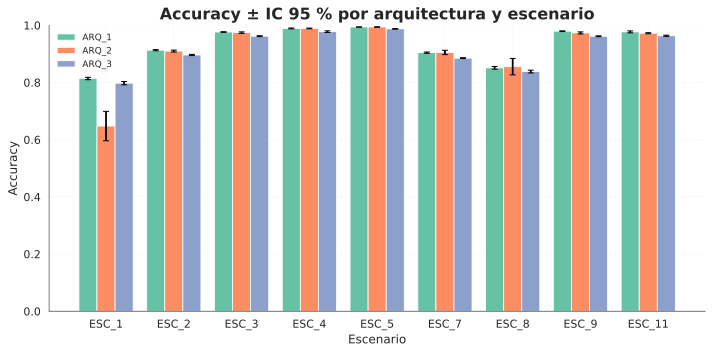

In [8]:
archs = agg["arch"].unique()
escs  = sorted(agg["esc"].unique(), key=lambda x: int(x.split("_")[1]))
x = np.arange(len(escs))
bar_w = 0.8 / len(archs)

fig, ax = plt.subplots(figsize=(10,5))
for i, arch in enumerate(archs):
    sub = agg[agg.arch == arch].set_index("esc").loc[escs]
    ax.bar(x + i*bar_w,
           sub.acc_mean,
           yerr=sub.acc_ci95,
           width=bar_w,
           label=arch,
           capsize=3)
ax.set_xticks(x + bar_w*(len(archs)-1)/2, escs)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Escenario")
ax.set_ylim(0, 1)
ax.set_title("Accuracy ± IC 95 % por arquitectura y escenario")
ax.legend()
plt.tight_layout(); plt.show()


In [9]:
pivot = df.groupby(["esc","arch"])["accuracy"].mean().unstack("arch")
pivot_clean = pivot.dropna(how="any")

if pivot_clean.shape[1] >= 3:          # ≥3 arquitecturas
    stat, p = stats.friedmanchisquare(*(pivot_clean[c] for c in pivot_clean.columns))
    print(f"Friedman χ²={stat:.3f}, p={p:.4f}")
    if p < 0.05:
        import scikit_posthocs as sp
        nemenyi = sp.posthoc_nemenyi_friedman(pivot_clean)
        display(nemenyi)
else:                                  # sólo 2 arquitecturas → Wilcoxon
    a, b = pivot_clean.columns
    stat, p = stats.wilcoxon(pivot_clean[a], pivot_clean[b])
    print(f"Wilcoxon W={stat:.3f}, p={p:.4f}")


Friedman χ²=10.889, p=0.0043


,ARQ_1,ARQ_2,ARQ_3
ARQ_1,1.000000,0.884741,0.006182
ARQ_2,0.884741,1.000000,0.025783
ARQ_3,0.006182,0.025783,1.000000


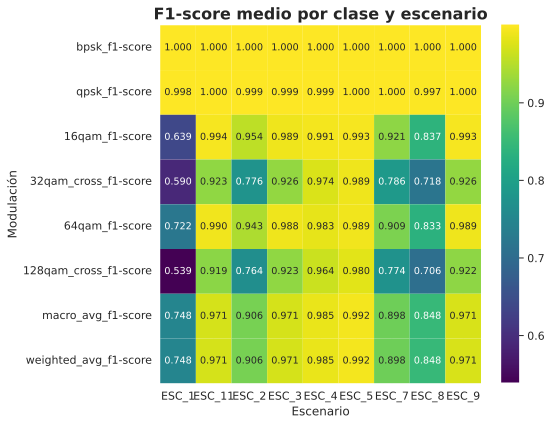

In [10]:
f1_cols = [c for c in df.columns if c.endswith("_f1-score")]
heat = df.groupby("esc")[f1_cols].mean().T  # filas=clases
plt.figure(figsize=(8,6))
sns.heatmap(heat, annot=True, fmt=".3f", cmap="viridis")
plt.title("F1-score medio por clase y escenario")
plt.ylabel("Modulación"); plt.xlabel("Escenario")
plt.tight_layout(); plt.show()

effects: 100%|██████████| 310/310 [00:00<00:00, 1508.14it/s]


,arch,esc,rep,param,bin_value,accuracy
0,ARQ_1,ESC_1,0,num_taps,2.00000,0.805339
1,ARQ_1,ESC_1,0,snr_db,0.19916,0.771987
2,ARQ_1,ESC_1,0,snr_db,0.60100,0.772657


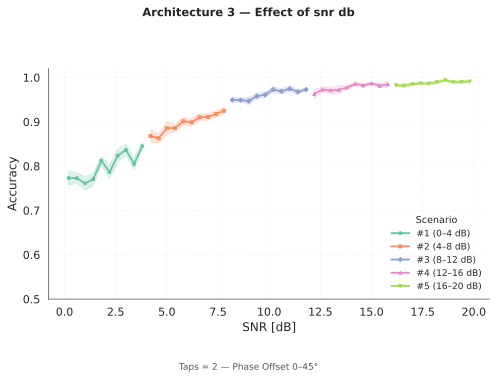

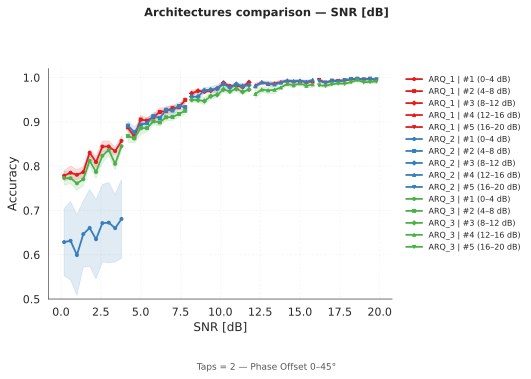

In [11]:
# -----------------------------------------------------------
# 10 · Channel-effect analysis (SNR · num_taps · phase_offset)
# -----------------------------------------------------------

# --- 10.0  Scenario dictionary labels ----------------------------------------------
def make_esc_label(param, esc):
    info = ESCS_BY_PARAM[param]["escs"][esc]
    esc = esc.replace("ESC_", "#")
    if param == "snr_db":
        return f"{esc} ({info['low']:.0f}–{info['high']:.0f} dB)"
    if param == "num_taps":
        return f"{esc} ({info['num_tap']} tap{'s'*(info['num_tap']>1)})"
    if param == "phase_offset":
        return f"{esc} ({info['low']:.0f}–{info['high']:.0f}°)"
    return esc

def constants_label(param) -> str:
    """Return nicely formatted string of fixed parameters."""
    cs   = ESCS_BY_PARAM[param]["constants"]
    parts = []
    if "snr_db" in cs:        parts.append(f"SNR {cs['snr_db']['low']:.0f}–{cs['snr_db']['high']:.0f} dB")
    if "num_taps" in cs:      parts.append(f"Taps = {cs['num_taps']}")
    if "phase_offset" in cs:  parts.append(f"Phase Offset {cs['phase_offset']['low']:.0f}–{cs['phase_offset']['high']:.0f}°")
    return " — ".join(parts)

# -----------------------------------------------------------
# 10.1  Load effects → long DataFrame
# -----------------------------------------------------------
import re, pandas as pd
def discover_effects(root: Path):
    return sorted(root.glob("ARQ_*/ESC_*/rep_*/reports/effects_report.json"))

def interval_midpoint(bin_str: str) -> float:
    """Return numeric midpoint of interval '(-0.1, 0.4]' or float if already numeric."""
    try:    return float(bin_str)
    except ValueError:
        nums = list(map(float, re.findall(r"[-+]?\d*\.?\d+(?:e[-+]?\d+)?", bin_str)))
        return sum(nums)/2 if len(nums)==2 else float("nan")

rows_eff = []
for p in tqdm(discover_effects(RESULTS_ROOT), desc="effects"):
    arch, esc, rep = parse_meta(p)
    for param, section in load_json(p)["effects"].items():
        if param not in ESCS_BY_PARAM:                     # skip unknown keys
            continue
        for bin_id, m in section["values"].items():
            rows_eff.append(dict(
                arch=arch, esc=esc, rep=rep, param=param,
                bin_value=interval_midpoint(bin_id),
                accuracy=m.get("Éxito", m.get("accuracy"))
            ))
effects_df = pd.DataFrame(rows_eff)
display(effects_df.head(3))

# -----------------------------------------------------------
# 10.2  Helpers (labels, palettes)
# -----------------------------------------------------------
import seaborn as sns, matplotlib.pyplot as plt, itertools

PALETTE_ESC   = sns.color_palette("Set2", 7)          # up to 7 scenarios
PALETTE_ARCH  = sns.color_palette("Paired", 10)       # up to 10 architectures
MARKERS_ESC   = ["o","s","D","^","v","P","X"]

def esc_marker(idx):   return MARKERS_ESC[idx % len(MARKERS_ESC)]
def esc_color(idx):    return PALETTE_ESC[idx % len(PALETTE_ESC)]
def arch_color(idx):   return PALETTE_ARCH[idx % len(PALETTE_ARCH)]

XLABEL = {"snr_db":"SNR [dB]", "phase_offset":"Phase offset [°]", "num_taps":"Number of taps"}

# -----------------------------------------------------------
# 10.3  Single-architecture curve
# -----------------------------------------------------------
def plot_effect_curve(df, arch: str, param: str):
    if param not in ESCS_BY_PARAM: raise ValueError(param)
    escs = ESCS_ORDER[param]

    sub = df[(df.arch==arch)&(df.param==param)&(df.esc.isin(escs))]
    if sub.empty: print("No data"); return

    fig, ax = plt.subplots(figsize=(7,4.5))
    mean = sub.groupby(["esc","bin_value"])["accuracy"].mean().unstack("esc")[escs]
    std  = sub.groupby(["esc","bin_value"])["accuracy"].std().unstack("esc")[escs]

    for j, esc in enumerate(escs):
        ax.plot(mean.index, mean[esc],
                color=esc_color(j), marker=esc_marker(j),
                label=make_esc_label(param, esc))
        ax.fill_between(mean.index, mean[esc]-std[esc], mean[esc]+std[esc],
                        color=esc_color(j), alpha=.22 if param!="num_taps" else 1)

    ax.set(xlabel=XLABEL[param], ylabel="Accuracy", ylim=(0.5,1.02))
    ax.grid(alpha=.18, ls="--")
    ax.legend(title="Scenario", fontsize=9, loc="lower right")

    fig.suptitle(f"{arch.replace('ARQ_', 'Architecture ')} — Effect of {param.replace('_',' ')}", weight="bold", y=1.04)
    fig.text(0.5, -0.08, constants_label(param), ha="center", fontsize=9, color="#555")
    plt.tight_layout(rect=[0,0,1,0.95])

# -----------------------------------------------------------
# 10.4  Multi-architecture comparison
# -----------------------------------------------------------
def plot_effect_compare(df, arch_list: list[str], param: str):
    if param not in ESCS_BY_PARAM: raise ValueError(param)
    escs = ESCS_ORDER[param]

    fig, ax = plt.subplots(figsize=(7.5,4.5))
    ls_cycle = itertools.cycle(["-"])

    for i, arch in enumerate(arch_list):
        sub = df[(df.arch==arch)&(df.param==param)&(df.esc.isin(escs))]
        if sub.empty: continue
        mean = sub.groupby(["esc","bin_value"])["accuracy"].mean().unstack("esc")[escs]
        std  = sub.groupby(["esc","bin_value"])["accuracy"].std().unstack("esc")[escs]

        for j, esc in enumerate(escs):
            ax.plot(mean.index, mean[esc],
                    color=arch_color_intense(i), linestyle=next(ls_cycle),
                    marker=esc_marker_intense(j),
                    label=f"{arch} | {make_esc_label(param,esc)}")
            ax.fill_between(mean.index, mean[esc]-std[esc], mean[esc]+std[esc],
                            color=arch_color_intense(i), alpha=.15 if param!="num_taps" else 0.3)

    ax.set(xlabel=XLABEL[param], ylabel="Accuracy", ylim=(0.5,1.02))
    ax.grid(alpha=.18, ls="--")
    ax.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)

    fig.suptitle(f"Architectures comparison — {XLABEL[param]}", weight="bold", y=1.04)
    fig.text(0.5, -0.08, constants_label(param), ha="center", fontsize=9, color="#555")
    plt.tight_layout(rect=[0,0,1,0.95])

# -----------------------------------------------------------
# 10.5  DEMO
# -----------------------------------------------------------
for p in ["snr_db"]:
    plot_effect_curve(effects_df, "ARQ_3", p)

for p in ["snr_db"]:
    plot_effect_compare(effects_df, ["ARQ_1", "ARQ_2", "ARQ_3"], p)